In [1]:
# Dependencies

import os
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt

import datapipe
from basicsr import calculate_psnr
from basicsr.data import build_dataloader, build_dataset
from basicsr.data.degradations import add_jpg_compression
from basicsr.utils import FileClient, imfrombytes, img2tensor, tensor2img, scandir

# Measuring Rate: Compression Ratio

For training, images were compressed using JPEG algorithms but still stored in `.png` format because we were only interested in the distortion effect of the process. Now, it is important to generate `.jpg` files so that the file size can be compared. The file size seems to decrease between the original png and the jpeg compressed image saved as a png, but I am not sure if this is the same decrease that would be seen between a png file and a jpeg compressed image saved as jpeg.

The quality factor parameter indicates what level of compression should be applied to an image. Different images will have different compression ratios with the same quality factor applied.

Useful link: https://micro.magnet.fsu.edu/primer/java/digitalimaging/processing/jpegcompression/

In [6]:
def compression_ratio(hq_path, lq_path):
    hq_size = os.stat(hq_path).st_size
    lq_size = os.stat(lq_path).st_size
    return hq_size / lq_size

hq_folder = 'datasets/ffhq/test/'
lq_folder = 'testdata/jpeg_qf10'
img_name = '69990'

hq_path = os.path.join(hq_folder, f'{img_name}.png')
lq_path = os.path.join(lq_folder, f'{img_name}.jpg')

print(f"With JPEG quality factor 10, compression ratio = {compression_ratio(hq_path, lq_path)}")

With JPEG quality factor 10, compression ratio = 52.04897959183673


There are different methods of compressing the images. We can compress using parameter JPEG_QUALITY_FACTOR in `cv2.imwrite`. Alternatively, we can perform compression and then save with 100 quality. 

In [21]:
hq_folder = 'datasets/ffhq/test'
lq1_folder = 'testdata/jpeg_10_512'
lq2_folder = 'testdata/jpeg10_alternative'
lq3_folder = 'testdata/jpeg10_alternative2'
lq4_folder = 'testdata/jpeg10_alternative3'
img_name = '69990'

hq_path = os.path.join(hq_folder, f'{img_name}.png')
lq1_path = os.path.join(lq1_folder, f'{img_name}.png')
lq2_path = os.path.join(lq2_folder, f'{img_name}.png')
lq3_path = os.path.join(lq3_folder, f'{img_name}.jpg')
lq4_path = os.path.join(lq4_folder, f'{img_name}.jpg')

print(f"original png image {os.stat(hq_path).st_size}")
print(f"compress then png save {os.stat(lq1_path).st_size}")
print(f"compress as you png save {os.stat(lq2_path).st_size}")
print(f"compress then jpg save {os.stat(lq3_path).st_size}")
print(f"compress as you jpg save {os.stat(lq4_path).st_size}")

original png image 1249696
compress then png save 196380
compress as you png save 196380
compress then jpg save 34932
compress as you jpg save 7479


Conclusion: must apply jpeg compression as we save the image.

# Measuring Rate: BPP

Bits Per Pixel (bpp) is another metric for the rate of the function.

In [38]:
def calculate_bpp(shape, encsize=None, path=None):
    if (encsize is None):
        encsize = os.stat(path).st_size
    
    return encsize*8 / (shape[0]*shape[1]) # assumes HWC

In [62]:
qf = 10

dataset_opt = {
    'name': 'FFHQJPEGTest',
    'type': 'FFHQJPEGDataset',
    'phase': 'test',
    'gt_size': 512,
    'scale': 1,
    'encsize': True,
    'qf': qf,
    'dataroot_gt': 'datasets/ffhq/test',
    'io_backend':
        {'type': 'disk'} 
}

test_set = build_dataset(dataset_opt)
test_loader = build_dataloader(
            test_set,
            dataset_opt,
            num_gpu=1,
            dist=False,
            sampler=None,
            seed=0)

data = next(iter(test_loader))
print(data['lq_path'])

['datasets/ffhq/test/69905.png']


Compare the file size to the raw encoding size.

In [63]:
print(f'Embedding vector has size {data['encsize'].item()} bytes')
path = 'testdata/jpeg_qf10/69905.jpg'
print(f'File has size {os.stat(path).st_size} bytes')

Embedding vector has size 35332 bytes
File has size 35332 bytes


We have shown that the embedding vector has the same size as the storage size reported by the OS function, possibly because the OS function ignores metadata overhead. We will use the embedding vector length from now on as our compressed size.

In [19]:
img_hq = data['gt']
img_lq = data['lq']
img_name = os.path.splitext(os.path.basename(data['lq_path'][0]))[0]
encsize = data['encsize'].item()
print(f"Compressed image has rate of {calculate_bpp(img_lq.shape, encsize=encsize)} bits per pixel")

Compressed image has rate of 0.269561767578125 bits per pixel


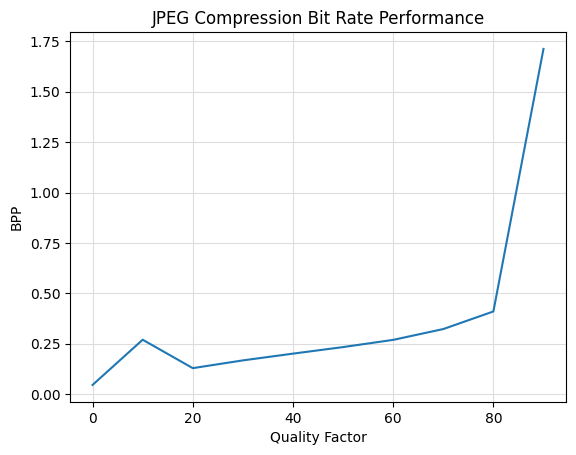

In [21]:
qf = [0,10,20,30,40,50,60,70,80,90]
bpp = []

for factor in qf:
    path = os.path.join(f"testdata/jpeg_qf{factor}/",f"{img_name}.jpg")
    bpp.append(calculate_bpp(img_lq.shape, path=path))

fig, ax = plt.subplots()
ax.plot(qf, bpp)
ax.set_title('JPEG Compression Bit Rate Performance')
ax.set_xlabel('Quality Factor')
ax.set_ylabel('BPP')
ax.grid(which='major', color='#DDDDDD', linewidth=0.8)
ax.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
fig.show()

# Measuring Distortion: PSNR

The `BasicSR` library provides a PSNR functionm, but it seems to give very high PSNR readings. An alternative PSNR function is defined for comparison as well as RMSE.

In [64]:
def calculate_psnr_alt(img1, img2, max_value=255):
    """"Calculating peak signal-to-noise ratio (PSNR) between two images."""
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return float('inf')
    return 20 * np.log10(max_value / (np.sqrt(mse)))

def calculate_mse(img1, img2):
    return np.mean((img1 - img2) ** 2)

def calculate_rmse(img1, img2):
    return np.sqrt(calculate_mse(img1, img2))

JPEG qf0 compression - PSNR 71.89541625976562 dB, RMSE 0.06482900679111481
JPEG qf10 compression - PSNR 78.64806365966797 dB, RMSE 0.029794560745358467
JPEG qf20 compression - PSNR 81.10221099853516 dB, RMSE 0.022461028769612312
JPEG qf30 compression - PSNR 82.35672760009766 dB, RMSE 0.01944032683968544
JPEG qf40 compression - PSNR 83.20706176757812 dB, RMSE 0.017627350986003876
JPEG qf50 compression - PSNR 83.92213439941406 dB, RMSE 0.01623428985476494
JPEG qf60 compression - PSNR 84.46951293945312 dB, RMSE 0.01524279173463583
JPEG qf70 compression - PSNR 85.23406219482422 dB, RMSE 0.013958445750176907
JPEG qf80 compression - PSNR 86.31028747558594 dB, RMSE 0.012331775389611721
JPEG qf90 compression - PSNR 88.36941528320312 dB, RMSE 0.00972902961075306


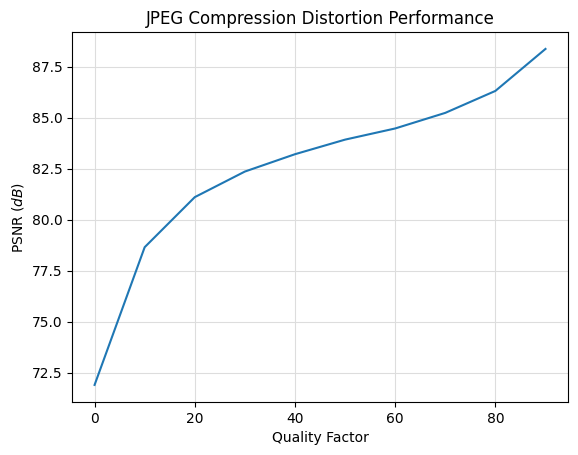

In [90]:
scale = 2

file_client = FileClient('disk')
    
img_bytes = file_client.get(hq_path, 'hq')
img_gt = imfrombytes(img_bytes, float32=True)
h, w = img_gt.shape[0:2]
img_hq = cv2.resize(img_gt, (w // scale, h // scale), interpolation=cv2.INTER_CUBIC)

qf = [0,10,20,30,40,50,60,70,80,90]
psnr = []
rmse = []

for factor in qf:
    img_lq = add_jpg_compression(img_hq, quality=factor)
    psnr.append(calculate_psnr_alt(img_hq, img_lq))
    rmse.append( calculate_rmse(img_hq, img_lq))
    print(f"JPEG qf{factor} compression - PSNR {psnr[-1]} dB, RMSE {rmse[-1]}")

fig, ax = plt.subplots()
ax.plot(qf, psnr)
ax.set_title('JPEG Compression Distortion Performance')
ax.set_xlabel('Quality Factor')
ax.set_ylabel('PSNR ($dB$)')
ax.grid(which='major', color='#DDDDDD', linewidth=0.8)
ax.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
fig.show()

# RD Curve

A compression algorithm is characterised by its RD curve, which conveys the relationship between its distortion performance and the compression level

In [60]:
gt_folder = 'datasets/ffhq/test'
file_client = FileClient('disk')

qf = range(0, 100, 10)
print(qf)
scale = 2

psnr = []
bpp = []

for factor in qf:
    paths = [os.path.join(gt_folder, v) for v in list(scandir(gt_folder))]
    
    psnr.append(0)
    bpp.append(0)
    
    for gt_path in paths:
    
        # Load gt images. Dimension order: HWC; channel order: BGR;
        # image range: [0, 1], float32.
        img_bytes = file_client.get(gt_path, 'gt')
        img_gt = imfrombytes(img_bytes, float32=True)

        # generate lq image
        # downsample
        h, w = img_gt.shape[0:2]
        img_hq = cv2.resize(img_gt, (w // scale, h // scale), interpolation=cv2.INTER_CUBIC)
        # add JPEG compression
        img_lq, encsize = add_jpg_compression(img_hq, quality=factor, size = True)
        
        # BGR to RGB, HWC to CHW, numpy to tensor
        img_hq, img_lq = img2tensor([img_hq, img_lq], bgr2rgb=True, float32=True)
        img_lq = torch.clamp((img_lq * 255.0).round(), 0, 255) / 255.
        
        img_hq, img_lq = tensor2img([img_hq, img_lq])
        
        # Calculate PSNR
        psnr[-1] += calculate_psnr(img_hq, img_lq, 0)
    
        # Calculate BPP
        # Function works with HWC dimension ordering
        bpp[-1] += calculate_bpp(img_lq.shape, encsize=encsize)
    
    psnr[-1] = psnr[-1] / len(paths)
    bpp[-1] = bpp[-1] / len(paths)
    
    print(f"JPEG qf{factor} compression - PSNR {psnr[-1]} dB, BPP {bpp[-1]}")
    
# Profile our model trained on JPEG qf10
restored_folder = 'results/inn_jpeg10_compression/restored_faces'
res_psnr = 0
paths = [os.path.join(restored_folder, v) for v in list(scandir(restored_folder))]
for path in paths:
    img_bytes = file_client.get(path, 'res')
    img_res = imfrombytes(img_bytes, float32=True)
    
    img_name = os.path.splitext(os.path.basename(path))[0]
    gt_path = os.path.join(gt_folder, f'{img_name}.png')
    
    img_bytes = file_client.get(gt_path, 'gt')
    img_gt = imfrombytes(img_bytes, float32=True)

    # generate lq image
    # downsample
    h, w = img_gt.shape[0:2]
    img_hq = cv2.resize(img_gt, (w // scale, h // scale), interpolation=cv2.INTER_CUBIC) 
    
    res_psnr += calculate_psnr(img_hq, img_res, 0)

res_psnr = res_psnr / len(paths) 

range(0, 100, 10)
JPEG qf0 compression - PSNR 22.452566788078386 dB, BPP 0.16686798095703126
JPEG qf10 compression - PSNR 28.288348728093197 dB, BPP 0.265042724609375
JPEG qf20 compression - PSNR 30.66290835353776 dB, BPP 0.38778472900390626
JPEG qf30 compression - PSNR 31.87945575844135 dB, BPP 0.49850311279296877
JPEG qf40 compression - PSNR 32.674767254934906 dB, BPP 0.595843505859375
JPEG qf50 compression - PSNR 33.30836540171738 dB, BPP 0.6916702270507813
JPEG qf60 compression - PSNR 33.91955131423344 dB, BPP 0.7974566650390625
JPEG qf70 compression - PSNR 34.745577915668015 dB, BPP 0.9651593017578125
JPEG qf80 compression - PSNR 35.93516176295289 dB, BPP 1.245867919921875
JPEG qf90 compression - PSNR 38.07953475721773 dB, BPP 1.931898193359375


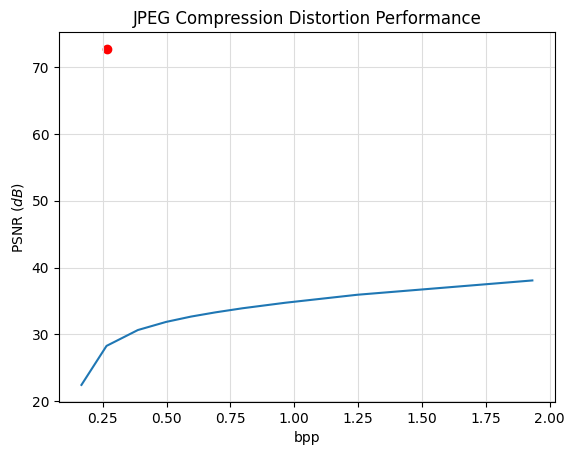

In [61]:
# Plot results
fig, ax = plt.subplots()
ax.plot(bpp, psnr)
ax.scatter([bpp[1]],[res_psnr], color='r')
ax.set_title('JPEG Compression Distortion Performance')
ax.set_xlabel('bpp')
ax.set_ylabel('PSNR ($dB$)')
ax.grid(which='major', color='#DDDDDD', linewidth=0.8)
ax.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
fig.show()   

# Test Set